In [213]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import akshare as ak
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from database.downloader.downloader_base import DownloaderBase
import database.database_config as db_config

pd.options.display.max_rows=None
pd.options.display.max_columns=None

!python --version

Python 3.8.10


In [214]:
# 绘图相关函数
def plot_series_dist(series):
    data = series
    # 使用matplotlib画直方图
    plt.hist(data, bins=60, edgecolor='k', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Data')
    plt.show()

In [216]:
class PreProcessing:
    def __init__(self, db_downloader:DownloaderBase) -> None:
        self.db_downloader = db_downloader

    # def _build_cls_label(self, dataframe):
    #     N = 1
    #     df = dataframe.copy()
    #     df['label'] = ((df['open'].shift(-N-1) / df['open'].shift(-1) - 1) > 0).astype(int)
    #     df = df[df['high'].shift(-1) != df['low'].shift(-1)]
    #     return df[['datetime', 'label']]

    def _build_reg_label(self, stock_dataframe):
        N = 5 # 最大持仓周期 = N天，第N+1天开盘卖出
        df = stock_dataframe.copy()
        # 标签构建
        df['label'] = df['open'].shift(-N-1) / df['open'].shift(-1) - 1 # 计算第N日收益率
        # 极值处理 - quantile处理
        df['label'] = np.clip(
            df['label'], 
            np.nanquantile(df['label'], 0.01), 
            np.nanquantile(df['label'], 0.99),
            )
        # 过滤第二天一字涨停情况
        df = df[df['high'].shift(-1) != df['low'].shift(-1)]
        return df[['datetime', 'label']]
    
    # def _build_reg_label(self, stock_dataframe):
    #     N = 10  # 最大持仓周期 = N天
    #     df = stock_dataframe.copy()
    #     # 计算未来N天内的最高收盘价
    #     df['max_open_future'] = df['open'].shift(-N).rolling(window=N).max()
    #     # 计算标签：即未来N天内最大收益率
    #     df['label'] = df['max_open_future'] / df['open'].shift(-1) - 1
    #     # 可选的极值处理 - quantile处理
    #     df['label'] = np.clip(
    #         df['label'],
    #         np.nanquantile(df['label'], 0.01),
    #         np.nanquantile(df['label'], 0.99),
    #     )
    #     # 过滤第二天一字涨停情况
    #     df = df[df['high'].shift(-1) != df['low'].shift(-1)]
    #     return df[['datetime', 'label']]
    
    # def _build_cls_label(self, dataframe, N=10, ATR_period=14):
    #     def calculate_atr(df, period=14):
    #         # True Range的计算
    #         df['high_low'] = df['high'] - df['low']
    #         df['high_cp'] = abs(df['high'] - df['close'].shift())
    #         df['low_cp'] = abs(df['low'] - df['close'].shift())
    #         tr = df[['high_low', 'high_cp', 'low_cp']].max(axis=1)
    #         return tr.rolling(window=period, min_periods=1).mean()
    #     df = dataframe.copy()
    #     df['ATR'] = calculate_atr(df, ATR_period)
    #     # 初始化标签列
    #     df['label'] = 0
    #     # 迭代每条记录
    #     for i in range(len(df)):
    #         if i + N >= len(df):
    #             continue  # 如果没有足够的未来数据，则跳过
    #         buy_price = df.at[i + 1, 'open']  # 明天的开盘价
    #         # 初始化未触发止盈止损标志
    #         triggered = False
    #         # 检查接下来的N天内是否满足条件
    #         for j in range(1, N + 1):
    #             current_close = df.at[i + j, 'close']
    #             atr_value = df.at[i + j, 'ATR']  # 第j天的ATR值
    #             take_profit = buy_price + 2 * atr_value
    #             stop_loss = buy_price - atr_value
    #             if current_close >= take_profit:
    #                 df.at[i, 'label'] = 1 # 止盈=1
    #                 triggered = True
    #                 break
    #             elif current_close <= stop_loss:
    #                 df.at[i, 'label'] = 2 # 止损=2
    #                 triggered = True
    #                 break
    #         # N天后既没有触发止盈也没有触发止损
    #         if not triggered:
    #             df.at[i, 'label'] = 0
    #     # 删除ATR列，因为它是一个中间计算列
    #     df = df[df['high'].shift(-1) != df['low'].shift(-1)]
    #     return df[['datetime', 'label', 'ATR']]

    def _process_one_stock(self, stock_code, start_date, end_date):
        stock_base = self.db_downloader._download_stock_base_info(stock_code) # 获取基础代码
        stock_individual = self.db_downloader._download_stock_individual_info(stock_code) # 获取profile信息
        stock_history = self.db_downloader._download_stock_history_info(stock_code, start_date, end_date) # 获取历史行情
        stock_indicator = self.db_downloader._download_stock_indicator_info(stock_code, start_date, end_date) # 获取指标数据
        stock_factor_date = self.db_downloader._download_stock_factor_date_info() # 获取日期特征
        stock_factor_qlib = self.db_downloader._download_stock_factor_qlib_info(stock_code, start_date, end_date) # 获取量价特征
        stock_label = self._build_reg_label(stock_history) # 构建Label
        stock_df = stock_base.merge(stock_individual, on=['stock_code']).merge(stock_history, on=['stock_code']).merge(stock_indicator, on=['stock_code', 'datetime']).merge(stock_label, on=['datetime']).merge(stock_factor_date, on=['datetime']).merge(stock_factor_qlib, on=['stock_code', 'datetime']) # 整合数据
        stock_df = stock_base \
            .merge(stock_individual, on=['stock_code', 'stock_name']) \
            .merge(stock_history, on=['stock_code']) \
            .merge(stock_indicator, on=['stock_code', 'datetime']) \
            .merge(stock_label, on=['datetime']) \
            .merge(stock_factor_date, on=['datetime']) \
            .merge(stock_factor_qlib, on=['stock_code', 'datetime']) # 整合数据
        stock_df = stock_df.dropna()
        return stock_df
    
    def _process_all_stock(self, code_type, start_date, end_date):
        # stock_code_list = list(ak.stock_info_a_code_name()['code'].unique()) # 获取A股所有股票列表
        stock_code_list = list(ak.index_stock_cons(code_type)['品种代码'].unique()) # 获取沪深300的股票代码列表
        stock_df_list = []
        for stock_code in tqdm(stock_code_list, desc=f'Process: {code_type} ...'):
            stock_df = self._process_one_stock(stock_code, start_date, end_date)
            if not stock_df.empty:
                stock_df_list.append(stock_df)
        return pd.concat(stock_df_list)

In [217]:
db_conn = sqlite3.connect('../database/hh_quant.db')
db_downloader = DownloaderBase(db_conn, db_config)
proprocessor = PreProcessing(db_downloader=db_downloader)

In [218]:
df = proprocessor._process_all_stock(code_type='000016', start_date='20130101', end_date='20191231')
# df = proprocessor._process_one_stock('601398', start_date='20130101', end_date='20181231')
# df = proprocessor.db_downloader._download_stock_history_info('601398', start_date='20130101', end_date='20181231')

Process: 000016 ...: 100%|██████████| 50/50 [00:05<00:00,  8.65it/s]


In [219]:
def extract_train_val_data(df, train_start_date, train_end_date, val_start_date, val_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date = pd.to_datetime(train_end_date)
    val_start_date = pd.to_datetime(val_start_date)
    val_end_date = pd.to_datetime(val_end_date)
    train_data = df[(pd.to_datetime(df['datetime']) >= train_start_date) & (pd.to_datetime(df['datetime']) <= train_end_date)]
    val_data = df[(pd.to_datetime(df['datetime']) >= val_start_date) & (pd.to_datetime(df['datetime']) <= val_end_date)]

    print(f"train_data_size: {train_data.shape}")
    print(f"validation_data_size: {val_data.shape}")
    return train_data, val_data

train_data, val_data = extract_train_val_data(df, *['20130101', '20181231', '20190101', '20191231'])

train_data_size: (52378, 207)
validation_data_size: (9851, 207)


In [221]:
label_columns = ['label']
feature_columns = ['turnover_rate', 'pe_ttm', 'ps_ttm', 'pcf_ncf_ttm', 'pb_mrq', 'KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'HIGH0', 'HIGH1', 'HIGH2', 'HIGH3', 'HIGH4', 'LOW0', 'LOW1', 'LOW2', 'LOW3', 'LOW4', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'VOLUME1', 'VOLUME2', 'VOLUME3', 'VOLUME4', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'TSRANK5', 'TSRANK10', 'TSRANK20', 'TSRANK30', 'TSRANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN10', 'CNTN20', 'CNTN30', 'CNTN60', 'CNTD5', 'CNTD10', 'CNTD20', 'CNTD30', 'CNTD60', 'SUMP5', 'SUMP10', 'SUMP20', 'SUMP30', 'SUMP60', 'SUMN5', 'SUMN10', 'SUMN20', 'SUMN30', 'SUMN60', 'SUMD5', 'SUMD10', 'SUMD20', 'SUMD30', 'SUMD60', 'VMA5', 'VMA10', 'VMA20', 'VMA30', 'VMA60', 'VSTD5', 'VSTD10', 'VSTD20', 'VSTD30', 'VSTD60', 'WVMA5', 'WVMA10', 'WVMA20', 'WVMA30', 'WVMA60', 'VSUMP5', 'VSUMP10', 'VSUMP20', 'VSUMP30', 'VSUMP60', 'VSUMN5', 'VSUMN10', 'VSUMN20', 'VSUMN30', 'VSUMN60', 'VSUMD5', 'VSUMD10', 'VSUMD20', 'VSUMD30', 'VSUMD60']

train_label = np.array(train_data[label_columns])
train_features = np.array(train_data[feature_columns])

val_label = np.array(val_data[label_columns])
val_features = np.array(val_data[feature_columns])

In [257]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer, StandardScaler

preprocessing_pipeline = Pipeline([
        ('quantile_transformer', QuantileTransformer(output_distribution='uniform', n_quantiles=1000)),
        # ('standard_scaler', StandardScaler())
        # ('kbins_discretizer', KBinsDiscretizer(n_bins=20, encode='onehot', strategy='quantile'))
    ])

train_features = preprocessing_pipeline.fit_transform(train_features)
val_features = preprocessing_pipeline.transform(val_features)

print(train_features.shape)

(52378, 182)


In [258]:
import tensorflow as tf

# 只使用CPU进行训练
tf.config.set_visible_devices([], 'GPU')

# 打印Tensorflow版本
print(f"Tensorflow Version: {tf.__version__}")

# 检查是否有可用的GPU设备
if tf.test.is_built_with_cuda():
    print("TensorFlow GPU version is installed")
else:
    print("TensorFlow CPU version is installed")

# 检查TensorFlow是否能够访问GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices available:", gpus)
else:
    print("No GPU devices found. Running on CPU.")

# !nvidia-smi

Tensorflow Version: 2.13.1
TensorFlow GPU version is installed
GPU devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [281]:
from model.layers import DnnLayer, BitWiseSeNet

class QuantModel(tf.keras.Model):
    def __init__(self, config={}, **kwargs):
        super(QuantModel, self).__init__(**kwargs)
        self.config = config

        self.dnn_layer = DnnLayer(
            hidden_units=self.config.get("dnn_hidden_units", [64, 32]),
            activation=self.config.get("dnn_activation", "relu"),
            dropout_rate=self.config.get("dnn_dropout", 0.2),
            use_bn=self.config.get("dnn_use_bn", True),
            l2_reg=self.config.get("l2_reg", 0.001),
            seed=self.config.get("seed", 1024),
        )
        self.senet_layer = BitWiseSeNet()
        self.wide_output_layer = tf.keras.layers.Dense(1, activation=None)
        self.deep_output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        deep_output = inputs
        # Deep侧处理
        deep_output = self.senet_layer(deep_output, training=training)
        dnn_output = self.dnn_layer(deep_output, training=training)
        # Deep侧输出
        deep_logit = self.deep_output_layer(dnn_output)
        wide_logit = self.wide_output_layer(inputs)
        return deep_logit + wide_logit

In [282]:
model = QuantModel()
task_type = 'reg'

if task_type == 'reg':
    # 回归
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        loss = tf.keras.losses.MeanAbsoluteError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.MeanSquaredError(),
        ]
    )
else:
    # 分类
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.AUC(name='prc', curve='PR')
            ]
    )

In [283]:
EPOCHS = 50
BATCH_SIZE = 256

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [284]:
baseline_history = model.fit(
    train_features,
    train_label,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_label))

Epoch 1/50


205/205 [==============================] - 2s 5ms/step - loss: 0.6269 - mean_absolute_error: 0.4952 - mean_squared_error: 0.4496 - val_loss: 0.2862 - val_mean_absolute_error: 0.1615 - val_mean_squared_error: 0.0415
Epoch 2/50
205/205 [==============================] - 1s 4ms/step - loss: 0.3928 - mean_absolute_error: 0.2739 - mean_squared_error: 0.1501 - val_loss: 0.2125 - val_mean_absolute_error: 0.0992 - val_mean_squared_error: 0.0154
Epoch 3/50
205/205 [==============================] - 1s 4ms/step - loss: 0.2797 - mean_absolute_error: 0.1719 - mean_squared_error: 0.0679 - val_loss: 0.1861 - val_mean_absolute_error: 0.0839 - val_mean_squared_error: 0.0112
Epoch 4/50
205/205 [==============================] - 1s 4ms/step - loss: 0.2076 - mean_absolute_error: 0.1107 - mean_squared_error: 0.0315 - val_loss: 0.1614 - val_mean_absolute_error: 0.0699 - val_mean_squared_error: 0.0078
Epoch 5/50
205/205 [==============================] - 1s 4ms/step - loss: 0.1615 - mean_absolute_error: 0.0

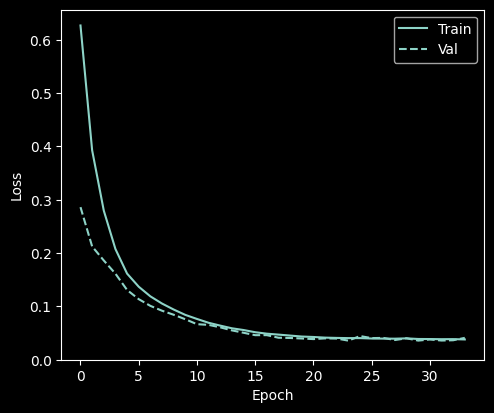

In [285]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  # metrics = ['loss', 'auc', 'precision', 'recall']
  metrics = ['loss']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'prc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()

plot_metrics(baseline_history)

loss :  0.035800687968730927
mean_absolute_error :  0.03392307460308075
mean_squared_error :  0.0021402204874902964

39/39 [==============================] - 0s 2ms/step
Legitimate Transactions Detected (True Negatives):  1462
Legitimate Transactions Incorrectly Detected (False Positives):  2941
Fraudulent Transactions Missed (False Negatives):  1664
Fraudulent Transactions Detected (True Positives):  3784
Total Fraudulent Transactions:  5448
Accuracy: 0.53, Precision: 0.56, Recall: 0.69


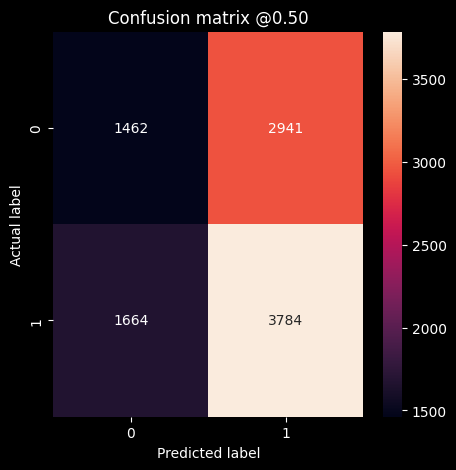

In [286]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

baseline_results = model.evaluate(val_features, val_label,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

true_label = (val_label>0).astype(int)
pred_label = (model.predict(val_features, batch_size=BATCH_SIZE) > 0).astype(int)

plot_cm(true_label, pred_label)

accuracy = accuracy_score(true_label, pred_label)
precision = precision_score(true_label, pred_label)
recall = recall_score(true_label, pred_label)
print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

In [287]:
model_pred_result = model.predict(val_features, batch_size=BATCH_SIZE)
output_df = val_data[['stock_code', 'industry', 'stock_name', 'datetime']]
# 回归结果
output_df['label'] = val_data['label']
output_df['label_pred'] = model_pred_result
output_df.to_pickle(f'../../Offline/backtest/backtest_data/000016/stock_selection_results_20190101.pkl')

31/39 [======================>.......] - ETA: 0s

39/39 [==============================] - 0s 2ms/step


In [5]:
def extract_train_val_data(df, train_start_date, train_end_date, val_start_date, val_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date = pd.to_datetime(train_end_date)
    val_start_date = pd.to_datetime(val_start_date)
    val_end_date = pd.to_datetime(val_end_date)
    train_data = df[(pd.to_datetime(df['datetime']) >= train_start_date) & (pd.to_datetime(df['datetime']) <= train_end_date)]
    val_data = df[(pd.to_datetime(df['datetime']) >= val_start_date) & (pd.to_datetime(df['datetime']) <= val_end_date)]

    print(f"train_data_size: {train_data.shape}")
    print(f"validation_data_size: {val_data.shape}")
    return train_data, val_data

def df_to_dataset(dataframe, feature_cols, label_cols, shuffle=True, batch_size=32):
    features = dataframe[feature_cols]
    labels = dataframe[label_cols]
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(features))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

def get_class_weights(label_series, udf_class_weight={}):
    class_weight = {}
    cnt_list = np.bincount(label_series).tolist()
    total_cnt = np.sum(cnt_list)
    for label, cnt in enumerate(cnt_list):
        class_weight[label] = (1 / cnt) * (total_cnt / 2.0) * udf_class_weight.get(label, 1)
    return class_weight
    

In [6]:
backtest_start_date = '20190101'
backtest_end_date = '20240101'
train_period = 6 # year：训练数据周期长度
update_period = 6 # month：模型更新周期长度

def get_rolling_date_period(backtest_start_date, backtest_end_date, training_period, update_period):
    backtest_start_date = datetime.strptime(backtest_start_date, '%Y%m%d')
    backtest_end_date = datetime.strptime(backtest_end_date, '%Y%m%d')
    result = []
    rolling_flag = True
    while rolling_flag:
        current_val_start_date = backtest_start_date
        current_val_end_date = current_val_start_date + relativedelta(months=update_period) - relativedelta(days=1)
        if current_val_start_date < backtest_end_date:
            current_train_start_date = current_val_start_date - relativedelta(years=training_period)
            current_train_end_date = current_val_start_date - relativedelta(days=1)
            result.append([
                current_train_start_date.strftime("%Y%m%d"),
                current_train_end_date.strftime("%Y%m%d"),
                current_val_start_date.strftime("%Y%m%d"),
                current_val_end_date.strftime("%Y%m%d")
                ])
            backtest_start_date += relativedelta(months=update_period) 
        else:
            rolling_flag=False # 结束滚动训练
    return result

rolling_period = get_rolling_date_period(backtest_start_date, backtest_end_date, train_period, update_period)
rolling_period

[['20130101', '20181231', '20190101', '20190630'],
 ['20130701', '20190630', '20190701', '20191231'],
 ['20140101', '20191231', '20200101', '20200630'],
 ['20140701', '20200630', '20200701', '20201231'],
 ['20150101', '20201231', '20210101', '20210630'],
 ['20150701', '20210630', '20210701', '20211231'],
 ['20160101', '20211231', '20220101', '20220630'],
 ['20160701', '20220630', '20220701', '20221231'],
 ['20170101', '20221231', '20230101', '20230630'],
 ['20170701', '20230630', '20230701', '20231231']]

In [23]:
from sklearn.preprocessing import KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='quantile')

In [37]:
# 计算sampleWeights
dataframe = df[['label']]
dataframe['bin_nums'] = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile').fit_transform(dataframe[['label']])
bin_counts = dataframe['bin_nums'].value_counts()
dataframe['sample_weight'] = dataframe['bin_nums'].map(lambda x: 1 / bin_counts.get(x))

In [9]:
from model import QuantModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer, StandardScaler

feature_config = {
    "target_feature_name": ["label"],
    "numeric_features": ['turnover_rate', 'pe_ttm', 'ps_ttm', 'pcf_ncf_ttm', 'pb_mrq', 'KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'HIGH0', 'HIGH1', 'HIGH2', 'HIGH3', 'HIGH4', 'LOW0', 'LOW1', 'LOW2', 'LOW3', 'LOW4', 'CLOSE0', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'VOLUME0', 'VOLUME1', 'VOLUME2', 'VOLUME3', 'VOLUME4', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'TSRANK5', 'TSRANK10', 'TSRANK20', 'TSRANK30', 'TSRANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN10', 'CNTN20', 'CNTN30', 'CNTN60', 'CNTD5', 'CNTD10', 'CNTD20', 'CNTD30', 'CNTD60', 'SUMP5', 'SUMP10', 'SUMP20', 'SUMP30', 'SUMP60', 'SUMN5', 'SUMN10', 'SUMN20', 'SUMN30', 'SUMN60', 'SUMD5', 'SUMD10', 'SUMD20', 'SUMD30', 'SUMD60', 'VMA5', 'VMA10', 'VMA20', 'VMA30', 'VMA60', 'VSTD5', 'VSTD10', 'VSTD20', 'VSTD30', 'VSTD60', 'WVMA5', 'WVMA10', 'WVMA20', 'WVMA30', 'WVMA60', 'VSUMP5', 'VSUMP10', 'VSUMP20', 'VSUMP30', 'VSUMP60', 'VSUMN5', 'VSUMN10', 'VSUMN20', 'VSUMN30', 'VSUMN60', 'VSUMD5', 'VSUMD10', 'VSUMD20', 'VSUMD30', 'VSUMD60'],
    "integer_categorical_features": ['month'],
    "string_categorical_features": ['industry', 'season'],
}
full_feature_names = feature_config.get('numeric_features', []) + feature_config.get('integer_categorical_features', []) + feature_config.get('string_categorical_features', [])
benchmark = '000016' # [上证50:000016, 沪深300:000300, 中证500:000905]所有股票作为训练数据
batch_size = 256

sample_period = [['20130101', '20181231', '20190101', '20191231']]
for date_period in tqdm(sample_period, desc='Rolling Training...'):
# for date_period in tqdm(rolling_period, desc='Rolling Training...'):
    train_start_date, train_end_date, val_start_date, val_end_date = date_period
    print(f"train_start: {train_start_date}, train_end: {train_end_date}, val_start: {val_start_date}, val_end: {val_end_date}")
    # 1. 获取所有股票信息
    df = proprocessor._process_all_stock(code_type=benchmark, start_date=train_start_date, end_date=val_end_date)
    # 2. 拆分训练数据&验证数据
    train_data, val_data = extract_train_val_data(df, train_start_date, train_end_date, val_start_date, val_end_date)
    # 2.1 计算类别权重（分类任务使用）
    # class_weights = get_class_weights(train_data['label'])
    # print(f"class_weights: {class_weights}")
    # 2.2 特征工程
    # 创建一个预处理管道
    preprocessing_pipeline = Pipeline([
        ('quantile_transformer', QuantileTransformer(output_distribution='uniform', n_quantiles=1000)),
        ('kbins_discretizer', KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='quantile'))
    ])
    norm_feature_columns = feature_config.get('numeric_features', [])
    train_data[norm_feature_columns] = preprocessing_pipeline.fit_transform(train_data[norm_feature_columns])
    val_data[norm_feature_columns] = preprocessing_pipeline.transform(val_data[norm_feature_columns])
    
    # 3. 构建训练集和验证集
    train_ds = df_to_dataset(train_data, full_feature_names, feature_config.get('target_feature_name', []), shuffle=True, batch_size=batch_size)
    val_ds = df_to_dataset(val_data, full_feature_names, feature_config.get('target_feature_name', []), shuffle=False, batch_size=batch_size)
    # 4. 配置模型相关参数
    model_config = {
        "seed": 1024,
        # "l2_reg": 0.001,
        "reduction_ratio": 3,
        "dnn_hidden_units": [256,128,64],
        "dnn_activation": 'relu',
        "dnn_dropout": 0.3,
        "dnn_use_bn": True,
        # "numeric_features_with_boundaries": {k: list(get_numeric_boundaries(train_data[k])) for k in feature_config.get('numeric_features', [])},
        "numeric_categorical_features_with_vocab": {k: list(train_data[k].unique()) for k in feature_config.get('numeric_features', [])},
        "integer_categorical_features_with_vocab": {k: list(train_data[k].unique()) for k in feature_config.get('integer_categorical_features', [])},
        "string_categorical_features_with_vocab": {k: list(train_data[k].unique()) for k in feature_config.get('string_categorical_features', [])},
        "feature_embedding_dims": 4,
    }
    # 5. 初始化模型
    model = QuantModel(model_config)

    # 8. 配置optimizer
    initial_learning_rate = 5e-4
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_learning_rate,
        decay_steps=(len(train_data) // batch_size)*5,
        decay_rate=1,
        staircase=False)
    # 配置模型compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # 分类任务
        loss = tf.keras.losses.MeanAbsoluteError(),
        # loss = tf.keras.losses.MeanSquaredError(),
        metrics=[
            # tf.keras.metrics.SparseCategoricalAccuracy() # 分类任务
            tf.keras.metrics.MeanAbsoluteError(),
            # tf.keras.metrics.MeanSquaredError(),
        ]
    )
    # 配置模型fit
    model.fit(
            train_ds, 
            validation_data=val_ds, 
            epochs=50,
            verbose=2,
            # class_weight=class_weights,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
                tf.keras.callbacks.TensorBoard(log_dir="./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)
            ],
    )
    # 9. 配置保存模型功能
    # model_save_path = f'./models/saved_model/model_of_{val_start_date}'
    # model.save(model_save_path)
    # best_model = tf.keras.models.load_model('./best_model')

    # 10. 记录预测集合
    model_pred_result = model.predict(val_ds)
    output_df = val_data[['stock_code', 'industry', 'stock_name', 'datetime']]
    # 回归结果
    output_df['label'] = val_data['label']
    output_df['label_pred'] = model_pred_result
    output_df.to_pickle(f'../../Offline/backtest/backtest_data/test/stock_selection_results_test.pkl')
    # output_df.to_pickle(f'../../Offline/backtest/backtest_data/{benchmark}/stock_selection_results_{val_start_date}.pkl')

Rolling Training...:   0%|          | 0/1 [00:00<?, ?it/s]

train_start: 20130101, train_end: 20181231, val_start: 20190101, val_end: 20191231


Process: 000016 ...: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


train_data_size: (52081, 207)
validation_data_size: (9683, 207)
Epoch 1/50


2024-03-26 10:26:57.119266: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14e4f0008f70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-26 10:26:57.119428: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-26 10:26:57.176602: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-26 10:26:57.424417: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


204/204 - 41s - loss: 0.8364 - mean_absolute_error: 0.8364 - val_loss: 0.3176 - val_mean_absolute_error: 0.3176 - 41s/epoch - 200ms/step
Epoch 2/50


Rolling Training...:   0%|          | 0/1 [05:48<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# model.summary()
# model_config

In [ ]:
# model_pred_result = model.predict(val_ds)
# output_df = val_data[['stock_code', 'industry', 'stock_name', 'datetime']]
# # 回归结果
# output_df['label'] = val_data['label']
# output_df['label_pred'] = model_pred_result
# output_df.to_pickle(f'../../Offline/backtest/backtest_data/test/stock_selection_results_test.pkl')

In [ ]:
# output_df.head()

In [ ]:
# train_data.columns[:100]

In [ ]:
# plot_series_dist(train_data['MIN60'])